## ChronosAblationQuarterlyFinetuned



In [ ]:
!pip install chronos-forecasting

In [ ]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")



Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Past covariates used: ['Q', 'Brent', 'OSEBX']

Fine-tune panel: 1980-12-10 → 1999-12-31 | n=4930

[Fine-tuning Chronos-2 on Norges Bank FX panel 1980–1999]
  Number of series: 11
  Total length across series: 52815
  Using prediction_length=32, num_steps=100, lr=2e-05, batch_size=2


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.407700
20,3.036000
30,1.864700
40,1.948600
50,1.595900
60,2.178300
70,3.170400
80,2.152600
90,1.925000
100,1.926200



Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – past macro covariates, finetuned) ===
Observations: 103
RMSE (level): 0.188821
MAE  (level): 0.145602
Directional accuracy: 72/102 (70.6%)

=== Diebold–Mariano vs Random Walk (past macro covariates, quarterly, finetuned) ===
Loss: MSE | horizon h=1
DM-statistic: -2.7092
p-value     : 0.0067


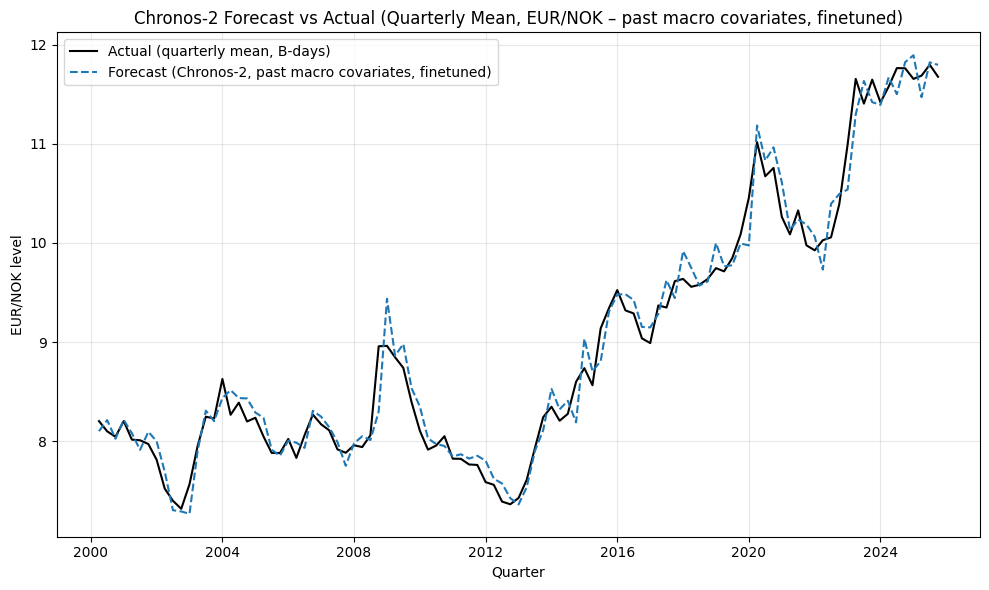

Saved: Chronos2Q_daily_pastcov_finetuned.png
Saved: Chronos2Q_daily_pastcov_finetuned.pdf


In [9]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels)
with DAILY past covariates restricted to the most important quarterly drivers:
  {Q, Brent, OSEBX}
+ fine-tuning on Norges Bank FX panel (1980–1999).

Design (samme som før):
  - Target: EUR_NOK (univariat)
  - Past covariates: Q, Brent, OSEBX (daglig, kun fortid)
  - Data: daily (kalenderdager), ffill
  - Cut: siste business day i forrige kvartal (basert på EUR_NOK B-dager)
  - Forecast: neste kalendarkvartal på daglig frekvens
              -> aggregeres til kvartalsvis snitt over business days
  - Ingen future_df -> ingen lekkasje fra fremtidige covariatebaner

Metrikker (identisk):
  - RMSE (level)
  - MAE (level)
  - Directional accuracy (QoQ)
  - Diebold–Mariano vs RW (MSE, h=1)

Figur (identisk stil):
  - Actual vs forecast (kvartalsnitt), uten bånd
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url_daily: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    url_finetune: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
    )
    q_freq: str = "Q"          # quarterly evaluation (Q-DEC)
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 100     # lengste kvartal ~92 dager
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_pastcov_finetuned.png"
    fig_pdf: str = "Chronos2Q_daily_pastcov_finetuned.pdf"

    # Fine-tuning hyperparameters (konservative)
    ft_prediction_length: int = 32
    ft_num_steps: int = 100
    ft_learning_rate: float = 2e-5
    ft_batch_size: int = 2
    ft_logging_steps: int = 10

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Viktigste drivere (past covariates)
IMPORTANT_PAST_COVS: List[str] = ["Q", "Brent", "OSEBX"]

FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily EUR_NOK + top past covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    CSV columns expected: Date, EUR_NOK, and IMPORTANT_PAST_COVS.

    Returns:
      S_b  : EUR_NOK on business days (B) ffill (for cuts and quarterly ground truth)
      DF_d : daily (D) DataFrame columns [EUR_NOK, IMPORTANT_PAST_COVS] (calendar days, ffill)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES} | set(IMPORTANT_PAST_COVS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in daily CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in [TARGET_SERIES] + IMPORTANT_PAST_COVS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily calendar, ffill
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Fine-tune panel loader (1980–1999)
# -----------------------------
def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    """
    CSV format: ds;AUD;CAD;CHF;DKK;GBP;ISK;JPY;NZD;SEK;USD;XDR
    Returns daily df indexed by DATE with float columns for the 11 FX series.
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for col in FINETUNE_FX_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df


# -----------------------------
# Chronos-2: base + fine-tuning
# -----------------------------
def build_base_chronos_pipeline() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA-enabled PyTorch and a recent NVIDIA driver.")
    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )
    return pipeline


def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
) -> BaseChronosPipeline:
    """Price-only finetuning: each FX column is a separate univariate item."""
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < CFG.ft_prediction_length * 2:
            continue
        train_inputs.append({
            "target": series,
            "past_covariates": {},
            "future_covariates": {},
        })

    if not train_inputs:
        raise RuntimeError("No valid series found for fine-tuning.")

    if CFG.verbose:
        total_len = sum(len(d["target"]) for d in train_inputs)
        print("\n[Fine-tuning Chronos-2 on Norges Bank FX panel 1980–1999]")
        print(f"  Number of series: {len(train_inputs)}")
        print(f"  Total length across series: {total_len}")
        print(
            f"  Using prediction_length={CFG.ft_prediction_length}, "
            f"num_steps={CFG.ft_num_steps}, lr={CFG.ft_learning_rate}, "
            f"batch_size={CFG.ft_batch_size}"
        )

    pipeline = pipeline.fit(
        inputs=train_inputs,
        prediction_length=CFG.ft_prediction_length,
        num_steps=CFG.ft_num_steps,
        learning_rate=CFG.ft_learning_rate,
        batch_size=CFG.ft_batch_size,
        logging_steps=CFG.ft_logging_steps,
    )
    return pipeline


# -----------------------------
# Chronos-2 predictor (univariate + past-only TOP covariates)
# -----------------------------
def build_model_chronos2(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[pd.DataFrame, int], np.ndarray]:

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")
        if "0.5" in df.columns:
            y = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            y = df["predictions"].to_numpy()
        elif {"forecast", "quantile"}.issubset(df.columns):
            y = df.loc[df["quantile"] == 0.5, "forecast"].to_numpy()
        else:
            raise RuntimeError(f"Unsupported Chronos schema: {list(df.columns)}")
        return np.asarray(y, dtype=float)

    def _forecast(hist_df: pd.DataFrame, H: int) -> np.ndarray:
        ctx = hist_df.tail(max_context).copy()
        df_ctx = ctx.reset_index().rename(columns={"DATE": "timestamp", TARGET_SERIES: "target"})
        df_ctx["item_id"] = TARGET_SERIES
        cols = ["item_id", "timestamp", "target"] + IMPORTANT_PAST_COVS
        df_ctx = df_ctx[cols]

        with torch.inference_mode():
            pred = pipeline.predict_df(
                df_ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                # No future_df -> covariates treated as past-only
            )
        med = _extract_median(pred)
        return med[:H]

    return _forecast


# -----------------------------
# Quarterly walk-forward with past covariates
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], np.ndarray],
) -> pd.DataFrame:
    """
    Quarterly walk-forward based on daily forecasts with past covariates only.
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        pf = forecast_fn(hist_df, H)
        if pf.shape[0] < H:
            dropped[str(q)] = f"horizon_short({pf.shape[0]})"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df


# -----------------------------
# Evaluation (level + direction) – identisk tekst
# -----------------------------
def evaluate_quarterly(eval_df: pd.DataFrame) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = hits / total if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK – past macro covariates, finetuned) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs Random Walk) – identisk tekst
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true, y_model, y_rw, h=1, loss="mse") -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower()=="mae" else (e_m**2)-(e_r**2)

    N = len(d)
    var_bar = np.var(d, ddof=1) / N
    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d.mean() / math.sqrt(var_bar)
    p_val = 2*(1-_normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk_quarterly(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (past macro covariates, quarterly, finetuned) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value: nan")


# -----------------------------
# Plot (quarterly) – identisk stil
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"], color="tab:blue", linestyle="--",
        label="Forecast (Chronos-2, past macro covariates, finetuned)"
    )

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – past macro covariates, finetuned)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url_daily)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Past covariates used: {IMPORTANT_PAST_COVS}")

    fx_panel = load_finetune_fx_panel(CFG.url_finetune)
    if CFG.verbose:
        print(f"\nFine-tune panel: {fx_panel.index.min().date()} → {fx_panel.index.max().date()} | n={len(fx_panel)}")

    base_pipeline = build_base_chronos_pipeline()
    ft_pipeline = finetune_chronos_on_nb_panel(base_pipeline, fx_panel)

    forecast_fn = build_model_chronos2(
        pipeline=ft_pipeline,
        max_context=CFG.max_context,
    )

    df_eval = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate_quarterly(df_eval)

    dm_against_random_walk_quarterly(eval_df, loss="mse", h=1)

    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()
